In [1]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
%matplotlib inline

h1b = pd.read_csv('data_virginia_clean_all.csv')
#random_index = np.random.choice(len(data.index), 1000000, replace=False)
#h1b = data.iloc[random_index].drop('Unnamed: 0', axis=1)
h1b.info()
#h1b['CASE_STATUS'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52439 entries, 0 to 52438
Data columns (total 11 columns):
CASE_STATUS           52439 non-null object
EMPLOYER_NAME         52439 non-null object
SOC_NAME              52439 non-null object
JOB_TITLE             52439 non-null object
FULL_TIME_POSITION    52439 non-null object
PREVAILING_WAGE       52439 non-null float64
YEAR                  52439 non-null float64
lon                   52439 non-null float64
lat                   52439 non-null float64
CITY                  52439 non-null object
STATE                 52439 non-null object
dtypes: float64(4), object(7)
memory usage: 4.4+ MB


In [2]:
#h1b['EMPLOYER_NAME'].value_counts()

In [2]:
import collections
from heapq import heapify, heappush,heappop
def key_words(s):
    temp=[]
    data=list(h1b[s])
    for one in data:
        t=one.split()
        for c in t:
            temp.append(c)
    count=collections.Counter(temp)
    return count
title_freq=key_words('JOB_TITLE')
full_time_freq=key_words('FULL_TIME_POSITION')
# sort_r=[]
# for k,v in r.items():
#     sort_r.append((v,k))

#temp_data=[]
for index, row in h1b.iterrows():
    full_time=row['FULL_TIME_POSITION']
    title=row['JOB_TITLE']
    if title_freq[title]==1 or full_time_freq[full_time]==1:
        continue
    else:
        temp_data.append(row)
#h1b = pd.DataFrame(temp_data)
#h1b.head()

NameError: name 'temp_data' is not defined

In [3]:
CERTIFIED_h1b=[]
CERTIFIED_WITHDRAWN_h1b=[]
DENIED_h1b=[]
WITHDRAWN_h1b=[]
count = 0
for index, row in h1b.iterrows():
    if row['CASE_STATUS']=='CERTIFIED':
        if count%2==0:
            CERTIFIED_h1b.append(row)
        count += 1
    elif row['CASE_STATUS']=='CERTIFIED-WITHDRAWN':
        CERTIFIED_WITHDRAWN_h1b.append(row)
    elif row['CASE_STATUS']=='DENIED':
        DENIED_h1b.append(row)
    elif row['CASE_STATUS']=='WITHDRAWN':
        WITHDRAWN_h1b.append(row)


In [4]:
FAIL_h1b=[]
for index, row in h1b.iterrows():
    if row['CASE_STATUS']=='CERTIFIED':
        continue
    else:
        t=row
        t['CASE_STATUS']='FAIL'
        FAIL_h1b.append(t)

In [5]:
prepared_h1b = pd.DataFrame(FAIL_h1b+CERTIFIED_h1b)
prepared_h1b['CASE_STATUS'].value_counts()

CERTIFIED    23185
FAIL          6070
Name: CASE_STATUS, dtype: int64

In [5]:
# CERTIFIED_h1b=pd.DataFrame(CERTIFIED_h1b)
# CERTIFIED_WITHDRAWN_h1b=pd.DataFrame(CERTIFIED_WITHDRAWN_h1b)
# DENIED_h1b=pd.DataFrame(DENIED_h1b)
# WITHDRAWN_h1b=pd.DataFrame(WITHDRAWN_h1b)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
# PCA for dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, chi2

#rbf_pca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names =attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    """Perform one-hot encoding to categorical features."""
    def __init__(self, cat_features):
        self.cat_features = cat_features

    def fit(self, X_cat, y=None):
        return self

    def transform(self, X_cat):
        X_cat_df = pd.DataFrame(X_cat, columns=self.cat_features)
        X_onehot_df = pd.get_dummies(X_cat_df, columns=self.cat_features)
        return X_onehot_df.values
    
num_attribs = ['PREVAILING_WAGE', 'YEAR', 'lon','lat']
cat_attribs = ['FULL_TIME_POSITION', 'CITY']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer',Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
cat_pipeline1 = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('onehot_encoder', CustomLabelBinarizer(cat_attribs)),
])
cat_pipeline2 = Pipeline([
    ('selector', DataFrameSelector(['JOB_TITLE'])),
    ('onehot_encoder', CustomLabelBinarizer(['JOB_TITLE'])),
    #('PCA', PCA(n_components = 50)),
    ('chi2_select', SelectKBest(chi2, k=100)),
])
cat_pipeline3 = Pipeline([
    ('selector', DataFrameSelector(['EMPLOYER_NAME'])),
    ('onehot_encoder', CustomLabelBinarizer(['EMPLOYER_NAME'])),
    #('PCA', PCA(n_components = 50)),
    ('chi2_select', SelectKBest(chi2, k=100)),
])
cat_pipeline4 = Pipeline([
    ('selector', DataFrameSelector(['SOC_NAME'])),
    ('onehot_encoder', CustomLabelBinarizer(['SOC_NAME'])),
    #('PCA', PCA(n_components = 50)),
    ('chi2_select', SelectKBest(chi2, k=100)),
])
cat_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline1', cat_pipeline1),
    ('cat_pipeline2', cat_pipeline2),
    ('cat_pipeline3', cat_pipeline3),
    ('cat_pipeline4', cat_pipeline4),
])

encoder = LabelEncoder()

h1b_X = prepared_h1b.drop('CASE_STATUS', axis=1)
h1b_y = 1 - encoder.fit_transform(prepared_h1b['CASE_STATUS'])

X_num = num_pipeline.fit_transform(h1b_X)
X_cat = cat_pipeline.fit_transform(h1b_X, h1b_y)

X = np.concatenate((X_num, X_cat), axis=1)
#train_set, test_set = train_test_split(prepared_h1b, test_size=0.2)
#train_X = train_set.drop('CASE_STATUS', axis=1)
#test_X = test_set.drop('CASE_STATUS', axis=1)

#X_test = full_pipeline.transform(test_X)

#y_train = 1 - encoder.fit_transform(train_set['CASE_STATUS'])
#y_test = 1 - encoder.transform(test_set['CASE_STATUS'])
#train_set['CASE_STATUS'].values
X_train, X_test, y_train, y_test = train_test_split(X, h1b_y, test_size=0.2)
print(X_train.shape, X_test.shape)

(23404, 367) (5851, 367)


In [14]:
# Random Forset Classifier with grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 800, 200
para_grid = [{'n_estimators':[800,1000], 'max_features':[160, 200, 240]}]
RF = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(RF, para_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
rnd_clf = grid_search.best_estimator_
rnd_clf

#rnd_clf = RandomForestClassifier(n_estimators=800, max_features=200, n_jobs=-1)
#rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=200, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
# SVM Classifier with grid search
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

# gamma:0.01 , C:0.1
para_grid = [{'gamma':[0.01, 0.001], 'C':[0.1, 0.01]}]
SVM = SVC(kernel='rbf')
grid_search = GridSearchCV(SVM, para_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
svm_clf = grid_search.best_estimator_
svm_clf

#svm_clf = SVC(kernel='rbf', gamma=0.01, C=0.1)
#svm_clf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
# Implementation of Boosting
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier#, GradientBoostingRegressor

# 800
para_grid = [{'n_estimators':[400, 600, 800, 1000]}]
ADA = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm='SAMME.R',learning_rate=0.5)
grid_search = GridSearchCV(ADA, para_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
ada_clf = grid_search.best_estimator_
ada_clf

#ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=800,algorithm='SAMME.R',learning_rate=0.5)
#ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)

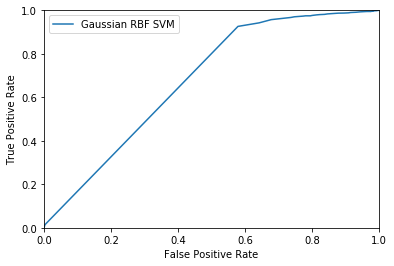

In [10]:
from sklearn.metrics import roc_curve, confusion_matrix

def plot_ROC(y, scores, label):
    fpr = []
    tpr = []
    threshold = np.linspace(min(scores), max(scores), 200)
    P = sum(y)
    N = len(y) - P
    for T in threshold:
        FP=0
        TP=0
        for j in range(len(y)):
            if (scores[j] > T):
                if (y[j]==1):
                    TP += 1
                else:
                    FP += 1
        fpr.append(FP/float(N))
        tpr.append(TP/float(P))
    #print(tpr,fpr)
    plt.plot(fpr, tpr, label=label)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_scores = svm_clf.decision_function(X_test)
#fpr,tpr,t = roc_curve(y_test, y_scores)
#plt.plot(fpr, tpr)

plot_ROC(y_test, y_scores, 'Gaussian RBF SVM')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation metrics

#y_pred_SVM = svm_clf.predict(X_test)
#f1_SVM = f1_score(y_test, y_pred_SVM)
#p_SVM = precision_score(y_test, y_pred_SVM)
#r_SVM = recall_score(y_test, y_pred_SVM)

y_pred_RF = rnd_clf.predict(X_test)
f1_RF = f1_score(y_test, y_pred_RF)
p_RF = precision_score(y_test, y_pred_RF)
r_RF = recall_score(y_test, y_pred_RF)

y_pred_ada = ada_clf.predict(X_test)
f1_ada = f1_score(y_test, y_pred_ada)
p_ada = precision_score(y_test, y_pred_ada)
r_ada = recall_score(y_test, y_pred_ada)

#print("%.4f %.4f %.4f"%(f1_SVM, p_SVM, r_SVM))
print("Random Forest: F1 %.4f, Precision %.4f, Recall %.4f"%(f1_RF, p_RF, r_RF))
print("AdaBoost: F1 %.4f, Precision %.4f, Recall %.4f"%(f1_ada, p_ada, r_ada))

Random Forest: F1 0.8907, Precision 0.8575, Recall 0.9266
AdaBoost:F1 0.8938, Precision 0.8341, Recall 0.9627


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation metrics

y_pred_SVM = svm_clf.predict(X_test)
f1_SVM = f1_score(y_test, y_pred_SVM)
p_SVM = precision_score(y_test, y_pred_SVM)
r_SVM = recall_score(y_test, y_pred_SVM)

print("SVM_RBF: F1 %.4f, Precision %.4f, Recall %.4f"%(f1_SVM, p_SVM, r_SVM))

AdaBoost:F1 0.8841, Precision 0.7923, Recall 1.0000


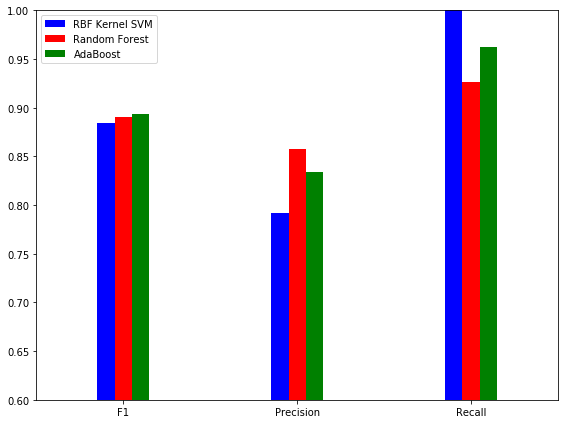

In [10]:

# plot comparison
def plot_compare(a, b, c):
    plt.figure(figsize=(8,6))
    plt.figure(1)
    index = np.arange(3)
    bar_width = 0.1
    rects1 = plt.bar(index - bar_width, (a[0],a[1],a[2]), bar_width, color='b', label='RBF Kernel SVM')
    rects2 = plt.bar(index, (b[0],b[1],b[2]), bar_width, color='r', label='Random Forest')
    rects3 = plt.bar(index + bar_width, (c[0],c[1],c[2]), bar_width, color='g', label='AdaBoost')
    plt.axis([-0.5,2.5,0.6,1])
    plt.xticks(index, ('F1', 'Precision', 'Recall'))
    plt.legend()
    plt.tight_layout()
    plt.show()

SVM=[0.8841, 0.7923, 1]
RF=[0.8907, 0.8575, 0.9266]
Ada=[0.8938, 0.8341, 0.9627]
plot_compare(SVM,RF,Ada)

In [ ]:
def use_state(array):
    res=[]
    for i in array:
        t=i.split(',')[-1].strip()
        res.append(t)
    return res

t=list(h1b['WORKSITE'])
x=use_state(t)
type(x)
h1b['WORKSITE']=pd.DataFrame(x,index=list(h1b.index.values))
h1b['WORKSITE'].value_counts()